# **EC-416 Pattern Recognition Innovative Project**

# Topic:- Image Caption Generator using ResNet50 model and Neural Networks

## Name: -Aditya Agrawal
## Roll No: - DTU/2K17/EC/008

<hr style="height:2px;border-width:0;color:gray;background-color:gray">

# **START**

In [1]:
from google.colab import drive
# Mount the Google Drive at mount
mount='/content/gdrive'
print("Colab: mounting Google drive on ", mount)

drive.mount(mount)

# Switch to the directory on the Google Drive that you want to use
import os
drive_root = mount + "/MyDrive/PR_Project_2K17_EC_008"

# Create drive_root if it doesn't exist
create_drive_root = True
if create_drive_root:
  print("\nColab: making sure ", drive_root, " exists.")
  os.makedirs(drive_root, exist_ok=True)

# Change to the directory
print("\nColab: Changing directory to ", drive_root)
%cd $drive_root

Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/MyDrive/PR_Project_2K17_EC_008  exists.

Colab: Changing directory to  /content/gdrive/MyDrive/PR_Project_2K17_EC_008
/content/gdrive/MyDrive/PR_Project_2K17_EC_008


In [2]:
import time
prog_start=time.time()

## Importing Libraries

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
from IPython.display import Image, display

In [4]:
import tensorflow as tf
import keras

In [5]:
from keras.preprocessing import image, sequence
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Flatten, Input
from keras.layers import Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential,Model
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

## Reading Flickr8 Dataset

In [6]:
# Load data
images_dir = os.listdir("Aditya_Flickr8k/Images/")

images_path = 'Aditya_Flickr8k/Images/'
captions_path = 'Aditya_Flickr8k/Flickr_TextData/Flickr8k.token.txt'
train_path = 'Aditya_Flickr8k/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = 'Aditya_Flickr8k/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = 'Aditya_Flickr8k/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [7]:
# Loading captions as values and images as key in dictionary
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

In [8]:
print("Number of captions of captions array: -",len(captions))
print("Number of images in training dataset: -",len(x_train))
print("Number of images in validation dataset: -",len(x_val))
print("Number of images in testing dataset: -",len(x_test))

Number of captions of captions array: - 40461
Number of images in training dataset: - 6001
Number of images in validation dataset: - 1001
Number of images in testing dataset: - 1001


In [9]:
print("Elements in captions array\n")
print(*captions[5000:5005], sep='\n')

print("\nElements in x_train array\n")
print(random.choices(x_train, k=5))

print("\nElements in x_val array\n")
print(random.choices(x_val, k=5))

print("\nElements in x_test array\n")
print(random.choices(x_test, k=5))

Elements in captions array

2098646162_e3b3bbf14c.jpg#0	A black and gray cat stands on a contracption while two big dogs stare at it .
2098646162_e3b3bbf14c.jpg#1	Two black and white dogs are looking at a grey and white kitty .
2098646162_e3b3bbf14c.jpg#2	Two black and white dogs look at a kitten perched on some equipment .
2098646162_e3b3bbf14c.jpg#3	Two black and white dogs looking at a black and white kitten who is sitting on top of a tank with hoses on it .
2098646162_e3b3bbf14c.jpg#4	Two dogs are staring at a grey and white cat .

Elements in x_train array

['590445887_4d4fa43923.jpg', '2088910854_c6f8d4f5f9.jpg', '191003287_2915c11d8e.jpg', '3430100177_5864bf1e73.jpg', '2808098783_c56b44befa.jpg']

Elements in x_val array

['3134341610_3c55e373a7.jpg', '2249480913_e1695e5c28.jpg', '1306145560_1e37081b91.jpg', '2187503678_fd743e0a00.jpg', '1874617189_e85d3f4326.jpg']

Elements in x_test array

['3107513635_fe8a21f148.jpg', '1773928579_5664a810dc.jpg', '3609032038_005c789f64.jpg', 

In [10]:
print("Example of captions for an image in tokens array: -\n")
tokens[random.choice(x_train)]

Example of captions for an image in tokens array: -



['A girl in a colorful skirt and blue shirt pounces onto her bed .',
 'A girl in colorful clothing is jumping on a bed with a color-block quilt .',
 'A woman is flying through the air and landing on a bed .',
 'A young girl in a colorful skirt is in the midst of falling onto a bed .',
 'Woman in multicolor skirt airborne above a bed with a multicolor bedspread .']

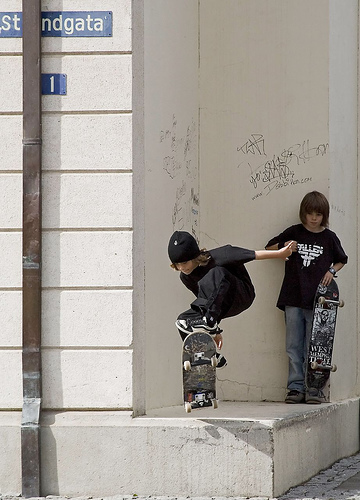

A boy takes a jump on his skateboard while another boy with a skateboard watches .
A child is performing a skateboard trick while another child with a skateboard leans on a wall .
A little boy skateboarder is doing a trick on his board while another young skateboarder watches .
a young boy skateboarder jumping on a platform on a skateboard .
Two skateboarders .


In [11]:
# displaying an image and captions given to it
Pos = random.randrange(0, len(captions), 5)

temp = captions[Pos].split('#')   

z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print (tokens[temp[0]][ix])

## Saving Train, Test and Validation Dataset

In [12]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('Files/flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('Files/flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('Files/flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [13]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> " + capt + " <end>"
        train_dataset.write((img + "\t" + caption + "\n").encode())
        train_dataset.flush()
train_dataset.close()

In [14]:
for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> " + capt + " <end>"
        test_dataset.write((img + "\t" + caption + "\n").encode())
        test_dataset.flush()
test_dataset.close()

In [15]:
for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> " + capt + " <end>"
        val_dataset.write((img + "\t" + caption + "\n").encode())
        val_dataset.flush()
val_dataset.close()

## Processing Images

In [16]:
ResNet50_Model_1 = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224,3), pooling='avg')

ResNet50_Model_1.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [17]:
temp = plot_model(ResNet50_Model_1, show_shapes=True, to_file="Files/ResNet50_Model_1.png")

In [18]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [19]:
start_time_1 = time.time()

In [20]:
img_train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = ResNet50_Model_1.predict(img).reshape(2048)
    img_train_data[ix] = pred
    print(ctr,end="\r")

1000
2000
3000


In [21]:
print("Time taken for processing images = %s minutes" % ((time.time() - start_time_1)/60))

Time taken for processing images = 4.349445247650147 minutes


In [22]:
print("Shape of img_train_data for one image")
img_train_data['2513260012_03d33305cf.jpg'].shape

Shape of img_train_data for one image


(2048,)

In [23]:
# opening train_encoded_images.p file and dumping it's content
with open("Files/train_encoded_images.p", "wb") as pickle_f:
    pickle.dump(img_train_data, pickle_f)

## Reading Train Dataset and Extracting Unique Words

In [24]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv("Files/flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print("Shape of Train Dataframe: -",ds.shape)

Shape of Train Dataframe: - (30000, 2)


In [25]:
pd_dataset.head(15)

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...
5,2903617548_d3e38d7f88.jpg,<start> A little baby plays croquet . <end>
6,2903617548_d3e38d7f88.jpg,<start> A little girl plays croquet next to a ...
7,2903617548_d3e38d7f88.jpg,<start> The child is playing croquette by the ...
8,2903617548_d3e38d7f88.jpg,<start> The kid is in front of a car with a pu...
9,2903617548_d3e38d7f88.jpg,<start> The little boy is playing with a croqu...


In [26]:
# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix,1])
print ("Number of captions/sentences in train dataset: -",len(sentences))

print("\nElements in setences array: -\n")
print(*sentences[0:5], sep='\n')

Number of captions/sentences in train dataset: - 30000

Elements in setences array: -

<start> A black dog is running after a white dog in the snow . <end>
<start> Black dog chasing brown dog through snow <end>
<start> Two dogs chase each other across the snowy ground . <end>
<start> Two dogs play together in the snow . <end>
<start> Two dogs running through a low lying body of water . <end>


In [27]:
# Splitting each captions stored in 'sentences' and storing them in 'words' as list of list
words = [i.split() for i in sentences]

print("Elements in words array: -\n")
print(*words[0:5], sep='\n')

Elements in words array: -

['<start>', 'A', 'black', 'dog', 'is', 'running', 'after', 'a', 'white', 'dog', 'in', 'the', 'snow', '.', '<end>']
['<start>', 'Black', 'dog', 'chasing', 'brown', 'dog', 'through', 'snow', '<end>']
['<start>', 'Two', 'dogs', 'chase', 'each', 'other', 'across', 'the', 'snowy', 'ground', '.', '<end>']
['<start>', 'Two', 'dogs', 'play', 'together', 'in', 'the', 'snow', '.', '<end>']
['<start>', 'Two', 'dogs', 'running', 'through', 'a', 'low', 'lying', 'body', 'of', 'water', '.', '<end>']


In [28]:
# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
    
print("Total number of words (including duplicates) in train dataset: -",len(unique),'\n')
print("Elements in unique array: -\n")
print(*unique[0:25], sep='\n')

Total number of words (including duplicates) in train dataset: - 413377 

Elements in unique array: -

<start>
A
black
dog
is
running
after
a
white
dog
in
the
snow
.
<end>
<start>
Black
dog
chasing
brown
dog
through
snow
<end>
<start>


In [29]:
unique = list(set(unique))
print("Total number of unique words in train dataset: -",len(unique))

vocab_size = len(unique)

print("\nElements in unique array: -\n")
print(*unique[0:25], sep='\n')

Total number of unique words in train dataset: - 8253

Elements in unique array: -

reacts
locker
writes
dump
waterfalls
Cami
wheels
bunch
built
croquet
pails
shorthair
window
wizard
waders
backstroke
walkway
bear
automobiles
medium-sized
outs
cabin
park-like
topped
latter


In [30]:
#Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [31]:
print("Elements in word_2_indices dictionary: -\n")
print(dict(list(word_2_indices.items())[0: 5])) 

print("\nElements in indices_2_word dictionary: -\n")
print(dict(list(indices_2_word.items())[0: 5])) 

Elements in word_2_indices dictionary: -

{'reacts': 0, 'locker': 1, 'writes': 2, 'dump': 3, 'waterfalls': 4}

Elements in indices_2_word dictionary: -

{0: 'reacts', 1: 'locker', 2: 'writes', 3: 'dump', 4: 'waterfalls'}


In [32]:
#UNK - Unknown Word

word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253

indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

In [33]:
print(word_2_indices['<start>'])
print(indices_2_word[4011])

print(word_2_indices['<end>'])
print(indices_2_word[8051])

7400
dumpsters
4092
cold


In [34]:
vocab_size = len(word_2_indices.keys())
print("Total number of unique words in train dataset: -",vocab_size)

Total number of unique words in train dataset: - 8254


In [35]:
#Max Length of Sentences
max_len = 0
#long=0
for i in sentences:
    i2 = i.split()
    if len(i2) > max_len:
        max_len = len(i2)
print("Length of longest caption: -",max_len)

Length of longest caption: - 40


## Creating Padded Sequences & Subsequent Words

In [36]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix,1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')
    
    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
    
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)


padded_sequences = np.asarray(padded_sequences,dtype=object)
subsequent_words = np.asarray(subsequent_words,dtype=object)

print("Shape of padded_sequences array",padded_sequences.shape)
print("Shape of subsequent_words array",subsequent_words.shape) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


Shape of padded_sequences array (30000,)
Shape of subsequent_words array (30000,)


In [37]:
idx= random.randrange(0, len(padded_sequences))
print("Example of a element in padded_sequences: -\n")
print(padded_sequences[idx])

Example of a element in padded_sequences: -

[[7400    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [7400 7127    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [7400 7127 6633    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [7400 7127 6633 6389    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [7400 7127 6633 6389 1286    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    

In [38]:
for ix in range(len(padded_sequences[idx])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[idx][ix][iy]], end =" ")
    print("\n")

print(len(padded_sequences[idx]))

<start> UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 

<start> The UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 

<start> The man UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 

<start> The man and UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 

<start> The man and woman UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 

<start> The man and woman are UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 



## Creating Arrays of Captions, Next Words, Images & Image Names

In [39]:
num_of_images = 2000 

In [40]:
start_time_2 = time.time()

In [41]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

for ix in range(num_of_images):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])
    print(ix,end="\r")

np.save("Files/captions.npy", captions)
np.save("Files/next_words.npy", next_words)

print("Shape of captions array: -",captions.shape)
print("Shape of next_words array: -",next_words.shape)

Shape of captions array: - (25493, 40)
Shape of next_words array: - (25493, 8254)


In [42]:
print("Time taken for creating captions and next_words array = %s minutes" % ((time.time() - start_time_2)/60))

Time taken for creating captions and next_words array = 6.857544843355814 minutes


In [43]:
with open('Files/train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

In [44]:
print("No of encoded_images: -",len(encoded_images))

No of encoded_images: - 3000


In [45]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0] in encoded_images.keys():
        imgs.append(list(encoded_images[ds[ix, 0]])) 

imgs = np.asarray(imgs)
print("Shape of imgs array: -",imgs.shape)

Shape of imgs array: - (15000, 2048)


In [46]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("Files/images.npy", images)

print("Shape of images array: -",images.shape)

Shape of images array: - (25493, 2048)


In [47]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("Files/image_names.npy", image_names)

print("Shape of image_names array: -",image_names.shape)

Shape of image_names array: - (25493,)


## Creating Image Caption Generator Model

In [48]:
captions = np.load("Files/captions.npy")
next_words = np.load("Files/next_words.npy")
images = np.load("Files/images.npy")
imag = np.load("Files/image_names.npy")

print("Shape of captions array: -",captions.shape)
print("Shape of next_words array: -",next_words.shape)
print("Shape of images array: -",images.shape)
print("Shape of image_names array: -",imag.shape)

Shape of captions array: - (25493, 40)
Shape of next_words array: - (25493, 8254)
Shape of images array: - (25493, 2048)
Shape of image_names array: - (25493,)


In [49]:
embedding_size = 128
max_len = 40

In [50]:
image_model = Sequential()
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 40, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


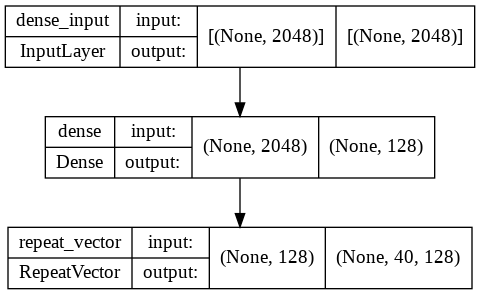

In [51]:
plot_model(image_model, show_shapes=True, to_file="Files/image_model.png")

In [52]:
language_model = Sequential()
language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           1056512   
                                                                 
 lstm (LSTM)                 (None, 40, 256)           394240    
                                                                 
 time_distributed (TimeDistr  (None, 40, 128)          32896     
 ibuted)                                                         
                                                                 
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


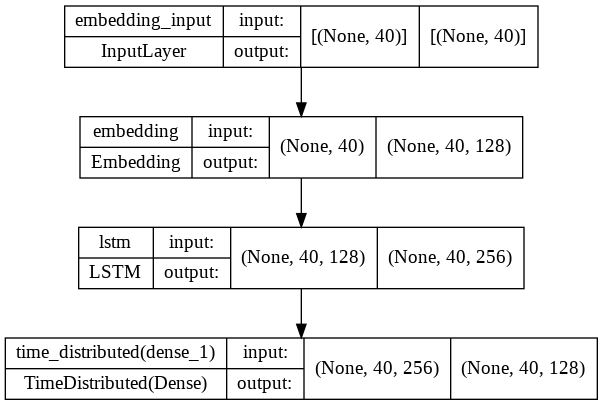

In [53]:
plot_model(language_model, show_shapes=True, to_file="Files/language_model.png")

In [54]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
Image_caption_model = Model(inputs=[image_model.input, language_model.input], outputs = out)

Image_caption_model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    
Image_caption_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 40)]         0           []                               
                                                                                                  
 dense_input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      1056512     ['embedding_input[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 128)          262272      ['dense_input[0][0]']            
                                                                                              

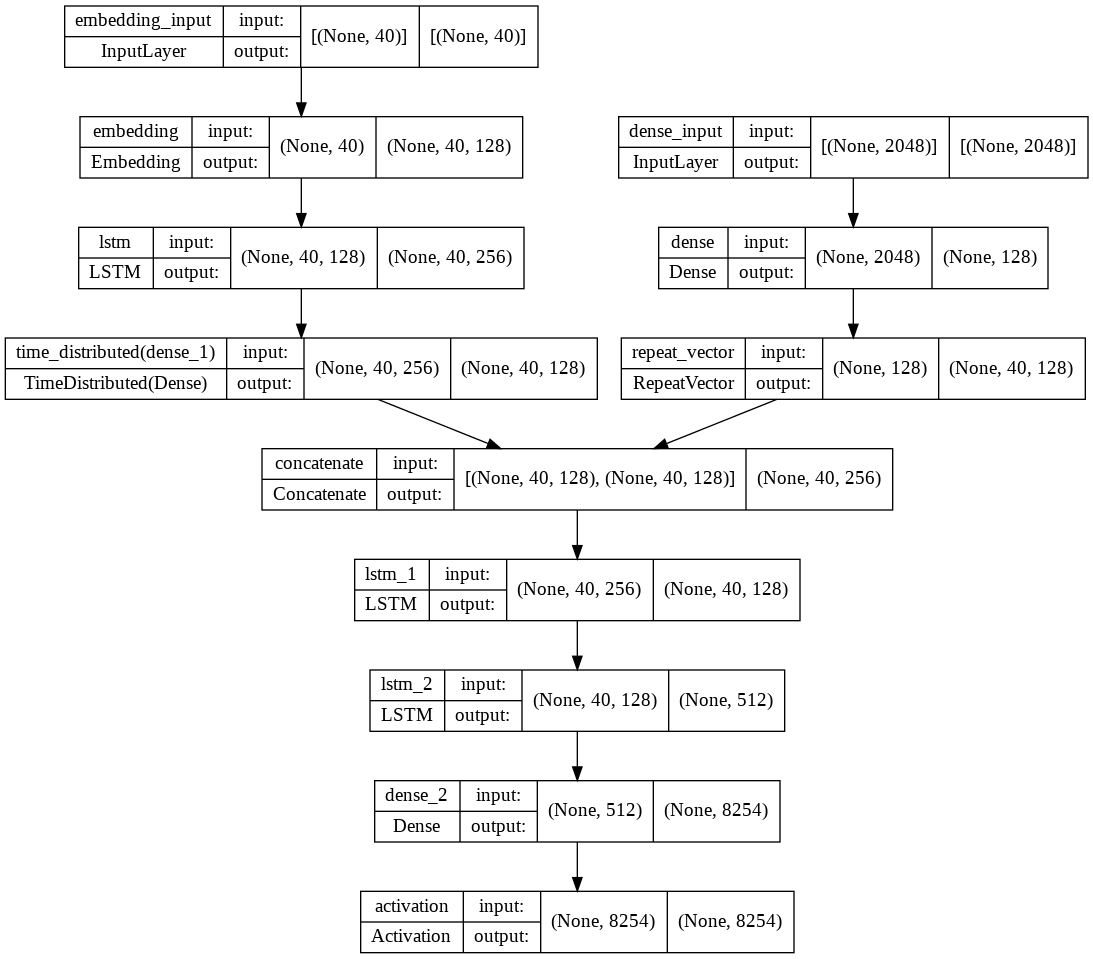

In [58]:
plot_model(Image_caption_model, show_shapes=True, to_file="Files/Image_caption_model.png")

In [59]:
start_time_3 = time.time()

In [60]:
hist = Image_caption_model.fit([images, captions], next_words, batch_size=512, epochs=210) 

Epoch 1/210
50/50 [==============================] - 4s 76ms/step - loss: 4.2010 - accuracy: 0.1933
Epoch 2/210
50/50 [==============================] - 4s 76ms/step - loss: 4.1029 - accuracy: 0.2047
Epoch 3/210
50/50 [==============================] - 4s 76ms/step - loss: 3.9505 - accuracy: 0.2312
Epoch 4/210
50/50 [==============================] - 4s 76ms/step - loss: 3.8370 - accuracy: 0.2506
Epoch 5/210
50/50 [==============================] - 4s 75ms/step - loss: 3.7394 - accuracy: 0.2575
Epoch 6/210
50/50 [==============================] - 4s 75ms/step - loss: 3.6608 - accuracy: 0.2679
Epoch 7/210
50/50 [==============================] - 4s 75ms/step - loss: 3.5865 - accuracy: 0.2729
Epoch 8/210
50/50 [==============================] - 4s 75ms/step - loss: 3.5137 - accuracy: 0.2793
Epoch 9/210
50/50 [==============================] - 4s 75ms/step - loss: 3.4498 - accuracy: 0.2844
Epoch 10/210
50/50 [==============================] - 4s 75ms/step - loss: 3.3854 - accuracy: 0.2922

In [61]:
print("Time taken to fit Image_caption_model = %s minutes" % ((time.time() - start_time_3)/60))

Time taken to fit Image_caption_model = 13.239662996927898 minutes


In [62]:
Image_caption_model.save_weights("Files/model_weights.h5")

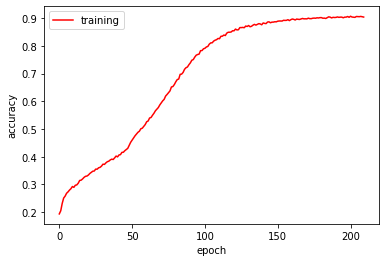

In [63]:
plt.figure(1)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(hist.history['accuracy'],'r')
plt.legend(['training'])
plt.savefig('Files/imgcap_accuarcy_plots.png')
plt.show()

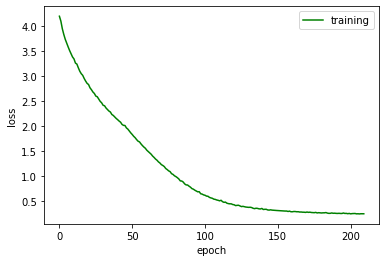

In [64]:
plt.figure(0)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(hist.history['loss'],'g')
plt.legend(['training'])
plt.savefig('Files/imgcap_loss_plots.png')
plt.show()

## Predicting Captions of Images

In [65]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [66]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [67]:
ResNet50_Model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [68]:
temp = plot_model(ResNet50_Model_2, show_shapes=True, to_file="Files/ResNet50_Model_2.png")

In [69]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = Image_caption_model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [70]:
Test_images_path="Aditya_Testing_Images"
fileList = os.listdir(Test_images_path) 

for i in fileList: 
    
    img = Test_images_path + "/" + i

    z = Image(filename=img)
    display(z)
    
    test_img = get_encoding(ResNet50_Model_2, img)
    Argmax_Search = predict_captions(test_img)
    print(Argmax_Search,"\n")

Output hidden; open in https://colab.research.google.com to view.

In [71]:
print("Time taken for program in = %s minutes" % ((time.time() - prog_start)/60))

Time taken for program in = 27.52637646198273 minutes


# END